In [1]:
import sys
import os
sys.path.append("..")
import torch
from tqdm.notebook import tqdm
import mango

In [2]:
size = 12
p = 0.5
gamma = 0.75

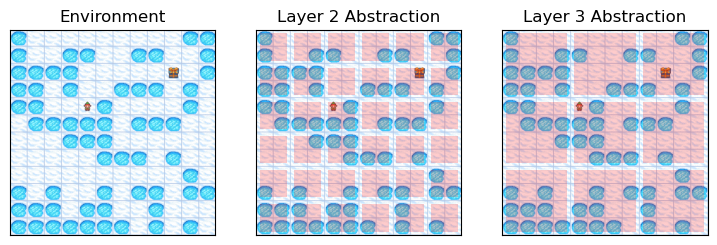

In [3]:
env_params={
    "map_name":"RANDOM", 
    "goal_pos":[], 
    "start_pos":[],
    "shape":(size, size), 
    "p":p, 
}
env = mango.environments.frozen_lake.CustomFrozenLakeEnv(**env_params)
env = mango.environments.frozen_lake.wrappers.ReInitOnReset(env, **env_params)
env = mango.environments.frozen_lake.wrappers.TensorObservation(env, one_hot=True)
env_shape = env.unwrapped.nrow, env.unwrapped.ncol

option_manager = mango.Mango(
    environment=env,  # type: ignore
    abstract_actions=[
        mango.actions.grid2d.SubGridMovement(
            cell_shape=cell_shape,
            grid_shape=env_shape,
            agent_channel=0,
            invalid_channel=1,
            reward=(1 - gamma),
        )
        for cell_shape in [(2, 2), (4, 4)]
    ],
    dynamic_policy_params=dict(
        policy_cls=mango.policies.DQNetPolicy,
        policy_params=dict(
            lr=1e-4,
            gamma=gamma,
            net_params=dict(
                hidden_channels=[4, 4],
                hidden_features=[],
                activation_out=torch.nn.Tanh(),
                # device=torch.device("cuda") if torch.cuda.is_available() else None,
            ),
        ),
    ),
)
option_manager.reset()
mango.environments.frozen_lake.plot_utils.plot_all_abstractions(option_manager)

In [4]:
N = 10000
alpha = 2
randomness = [((N-1-i)/N)**alpha for i in range(N)]
for layer in [1, 2]:
    for r in (pbar := tqdm(randomness)):
        pbar.set_description(f"randomness: {r:.3f}")
        option_manager.set_randomness(r, layer=layer)
        obs, reward, term, trunc, info = option_manager.explore(layer=layer, episode_length=3)
        option_manager.train(layer=layer)

mango.utils.plotting.plot_loss_reward(
    option_manager, mango.actions.grid2d.Actions, reward_lims=(0, 1.1 * (1 - gamma))
)
path_to_dir = f"trained_models/frozen_lake/map={size}x{size}_p={int(p*100)}%/"
os.makedirs(path_to_dir, exist_ok=True)
mango.saving.save_to(path=path_to_dir + "option_manager.pickle", obj=option_manager)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

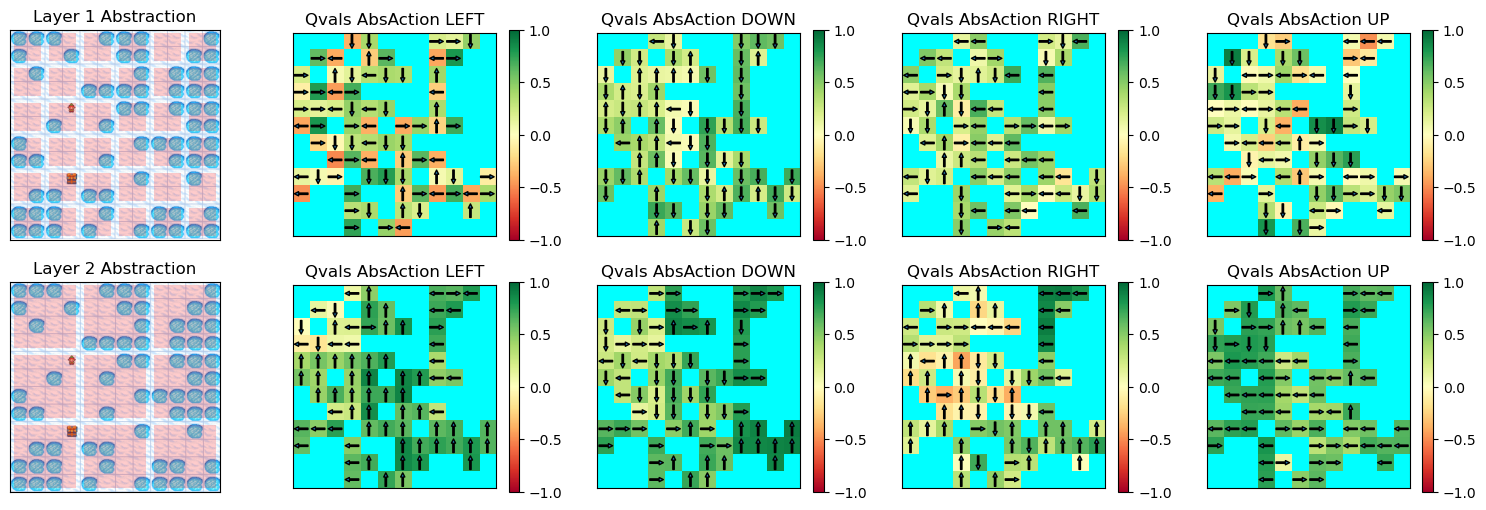

In [ ]:
obs, info = option_manager.reset()
mango.environments.frozen_lake.plot_utils.plot_all_qvals(option_manager)

LEFT
DOWN
RIGHT
UP


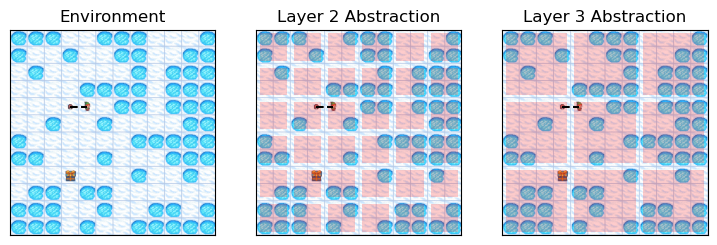

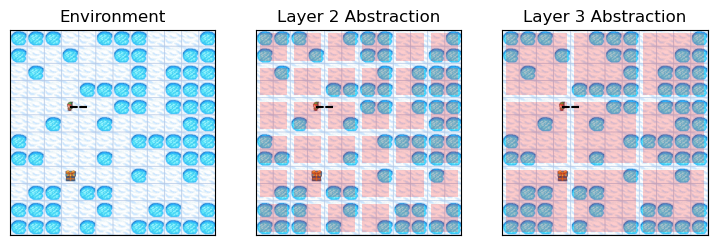

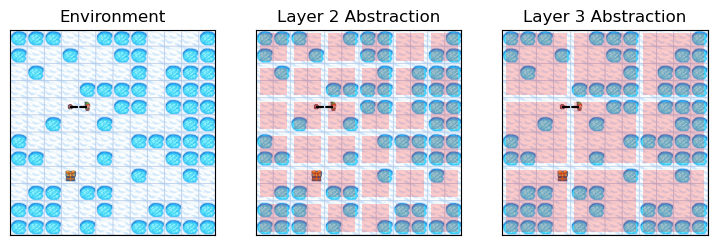

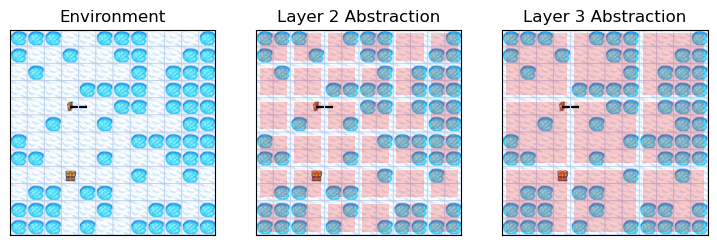

In [ ]:
trajectory = [obs]
for action in mango.actions.grid2d.Actions:
    print(action.name)
    for step in range(10):
        obs, reward, trunc, term, info = option_manager.step((-1, action.value))
        trajectory.extend(info["mango:trajectory"])
        if not info["mango:truncated"]:
            break
    mango.environments.frozen_lake.plot_utils.plot_all_abstractions(option_manager, trajectory)